# Winning the GHZ Game on Real IBM Quantum Computer<a name="top"></a>

*Lennart Schulze, Dr. Jan-Rainer Lahmann, October 2020*

updated to Qiskit v1.x by *Davide Moretti, November 2024*

The GHZ game is a serious game for quantum computing to show the quantum mechanical property of entanglement. Three players are asked for two different properties A and B of an object, an each property can be one of two conditions 1 or 0. When all are asked for property A, 1 should appear two times or zero times. When two players are asked for property B, 1 should appear three times ore one time. When the players don't know what the other two were asked, respectively, there is no strategy in classical logic that can lead to winning in all cases. Using Quantum Computing, however, there is. If you wish to find out more about this game, click [here](https://github.com/JanLahmann/Fun-with-Quantum/blob/master/GHZ-Game.ipynb).

The Qiskit built-in QASM Aer-simulator for running the Quantum circuit of the GHZ game is perfect, giving us the results that we expected from theory. In reality, however, the imperfection of real Quantum Computing hardware returns "noisy" output due to various sources of errors. Luckily, there is a variety of options available to mitigate these effects, some of which we will apply and inspect in this notebook.

In the following, we will have a closer look by:
1. Comparing IBM Quantum devices [[Go](#devices)]
2. Manually optimizing our circuit for a specific device [[Go](#manual)]
3. Using the Qiskit transpiler optimization [[Go](#transpiler)]
4. Best system ..? [[Go](#mem)]

Appendix [[Go](#appendix)]
* Running this notebook on real Quantum Computers [[Go](#appendix-b)]

_____

## Setup
[[Top](#top)]

We'll define our global variables: 3 qubits are needed for our circuit (GHZ state), and we use a high number of shots (=times a circuit is executed per run on a device, out of which the relative result distribution is calculated) to get consistent results:

In [9]:
# global vars
n = 3 # number of qubits
shots = 8000 # high number of shots per execution

For the remainder of this notebook, this will be our reference circuit for assessment. Note that the GHZ game uses 4 distinct circuits. These, however, only differ in their measurment base and order, but all have the same core - the GHZ state, which is the entanglement of 3 qubits (see part before the first barrier).

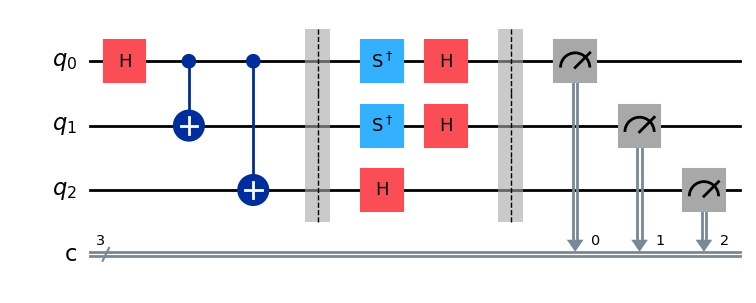

In [2]:
from qiskit import QuantumCircuit   # circuit creation

# basic circuit
name = "GHZ yyx default" # ghz in measurement base Y,Y,X
ghz = QuantumCircuit(n,n, name=name) # create circuit
ghz.h(0) # h gate
ghz.cx(0,1) # cnot gate
ghz.cx(0,2) # cnot gate
ghz.barrier()
ghz.sdg([0,1]) # s dagger gate
ghz.h(range(n)) # h gates
ghz.barrier()
ghz.measure(range(n), range(n)) # measurements
ghz.draw("mpl") # draw cirucit

In order to evaluate the accuracy of the results of executing the GHZ state on different devices and with different mitigation techniques, we need a metric which we will define as state accuracy. It represents the percentage of counts resulted from the experiment that belong to one of the four target states of the GHZ game ('001', '010', '100', '111'). Reaching either of them equals winning they game, therefore our metric represents the fidelity with which we win the GHZ game on our quantum computer. We will use the state accuracy to measure the effectiveness of our different optimization approaches.

In [7]:
expected_states = ['001', '010', '100', '111']  # target states

def get_state_accuracy(counts): # funciton to calculate state accuracy
    expected_counts = 0
    for state in counts.keys():
        if state in expected_states:
            expected_counts = expected_counts + counts[state]
    state_accuracy = expected_counts / shots
    return str(state_accuracy*100)+"%"

For reference, this is what the state accuracy would look like for results from a perfect backend (100%).

In [ ]:
from qiskit_ibm_runtime import Sampler # importing primitive for execution
from qiskit_aer import AerSimulator # importing simulator

backend = AerSimulator()
sampler = Sampler(mode=backend)
sampler.options.default_shots=shots

counts = sampler.run([ghz]).result()[0].data.c.get_counts() # execution on simulator
state_accuracy = get_state_accuracy(counts)

print(f"state accuracy on the simulator: {state_accuracy}")

state accuracy on the simulator: 100.0%


Note that the state accuracy is a custom metric designed for our needs. Depending on your research aim, other metrics such as the built-in [hellinger fidelity](https://qiskit.org/documentation/stubs/qiskit.quantum_info.hellinger_fidelity.html?highlight=hellinger_fidelity) might be a better choice to assess circuit execution on different devices.

Great, now we're all set to run our experiments!

## 1. Comparing IBM quantum devices<a name=devices><a/>
[[Top](#top)]

To start with, we need to find available quantum devices that are suitable to run our experiment. However, in case IBM Quantum devices are busy with jobs from other users, the execution of the following experiments take very long. To avoid this, we will use Qiskit built-in mock implementations of them, executed locally.

(If you want to try out this notebook on real systems, execute the cell above again and read the [appendix](#appendix-b) for detailed instructions.)

In [3]:
from qiskit_ibm_runtime.fake_provider import *     # mock devices

backends = [FakeWashingtonV2(), FakeTorino(), FakeSherbrooke(), FakeQuebec(), FakeBrisbane(), FakePrague(),
                FakeOsaka(), FakeKyiv()]

Now, let's compare the results from the execution of the GHZ circuit on these backends:

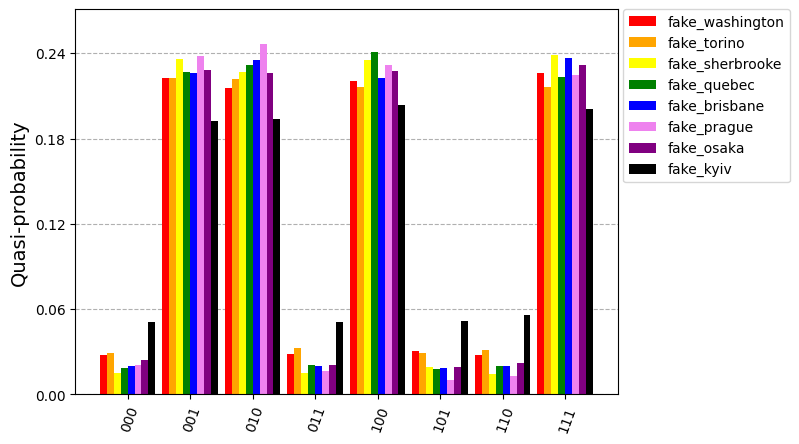

In [ ]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager # we'll talk about it at the end of chapter 3
from qiskit_ibm_runtime import Sampler  # primitives that run the circuit
from qiskit.visualization import plot_distribution # visualize results

results_backends = []

for backend in backends:
    
    sampler = Sampler(mode=backend)
    sampler.options.default_shots=shots

    pm = generate_preset_pass_manager(backend=backend, optimization_level=0) # pass manager, advanced way to transpile, see end of chapter 3 for more details
    circuit_isa = pm.run(ghz)

    counts = sampler.run([circuit_isa]).result()[0].data.c.get_counts() # get results
    state_accuracy = get_state_accuracy(counts) # calculate state accuracy
    results_backends.append((backend.backend_name, counts, state_accuracy)) # store results
    
# plot results
plot_distribution([counts for backend_name, counts, state_accuracy in results_backends],
                legend=[backend_name for backend_name, counts, state_accuracy in results_backends],
                sort="asc",
                color=["red", "orange", "yellow", "green", "blue", "violet", "purple", "black"],
                bar_labels=False)

The bars represent the relative amount (probability) to read a certain state from the execution of our circuit on the respective backend over the 8000 times the experiment was executed there. Remember that ideally, only four states should be returned by our circuit: 001, 010, 100, 100. Therefore, the best devices are those with the highest probability on these states while having the lowest on all other, undesired states.

To make it easier to interpret, we use the state accuracy as indicator of the results' quality:

In [7]:
# setup ordered table
import pandas as pd # handy tools for calculation

results_backends_table = pd.DataFrame(columns=["backend", "state_accuracy"]) # create table
for backend_name, counts, state_accuracy in results_backends:
    results_backends_table.loc[len(results_backends_table)] = [backend_name, state_accuracy] # put values into table
results_backends_table = results_backends_table.sort_values(by=["state_accuracy"], ascending=False).reset_index().iloc[:, 1:] # sort values
results_backends_table 


,backend,state_accuracy
0,fake_prague,94.0375%
1,fake_sherbrooke,93.5875%
2,fake_quebec,92.2625%
3,fake_brisbane,92.07499999999999%
4,fake_osaka,91.3625%
5,fake_washington,88.4875%
6,fake_torino,87.7%
7,fake_kyiv,79.05%


Now we know the ranking of the devices based on their fidelity. Let's pick one with a high state accuracy to test the optimization techniques in the remaining chapters. In addition, we will pick one system with a lower accuracy to compare against later.

In [8]:
# high accuracy
backend1 = FakeSherbrooke()

# lower accuracy
backend2 = FakeKyiv()

## 2. Manually optimizing circuits<a name=manual><a/>
[[Top](#top)]

Why is it that the IBM Quantum computer show different performances? As mentioned earlier, hardware optimization is a major research field at the moment. Essentially, our Quantum computer consist of different numbers of qubits that are connected with each other and manipulated according to our circuit. However, the way in which they are connected - the so called coupling map - as well the error rates when performing gates on single qubits, multiple qubits and when reading the state of the qubits differs across our devices due to manifacturing. Finally, the qubits posess varying coherence times (T1/T2). 

Let's have a closer look on how the coupling map and error rates look like on the "worst" among picked devices.

In [14]:
backend2.backend_name

'fake_kyiv'

On the Configuration tab you can see the coupling map of the devices. Qubits that are connected with a line can perform a multiple qubit gate such as CNOT directly. Trying to apply CNOT on non-connected qubits would require Qiskit to internally change the circuit before execution to fit it to the coupling map of the device. 

On the Error Map tab you can see the quality of each qubit and each connection where a darker color indicates a lower error rate (more desirable). If you are interested in the exact error rates, you can find them on the Qubit Properties tab (U2 - single qubit error rate, readout error rate) and on the Multi-Qubit Gates tab.

**Coupling Map based optimization**

The Qiskit transpiler prepares our code for execution on the real device. In case our circuit layout does not match the device's configuration, it will introduce swaps into our circuit so to make it applicable to the coupling map. Sometimes this can produce a worse accuracy than that from our original circuit. Therefore, let's try to create custom coupling map specific circuits of the GHZ state to avoid the transpiler interfering.

Backend 2:

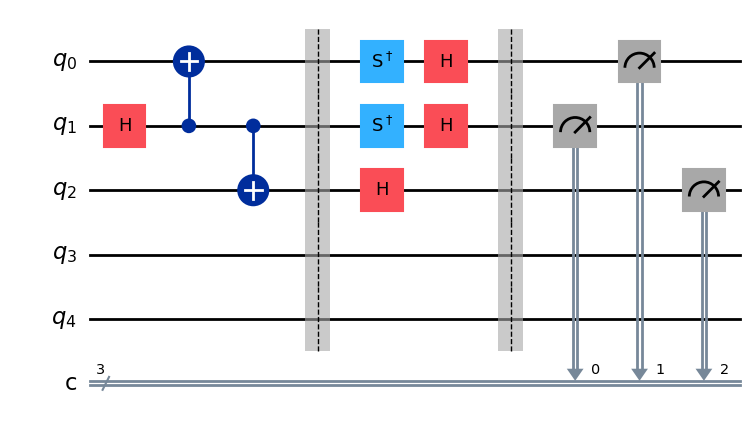

In [9]:
# backend2: create coupling map optimised circuit

# map: qubit 0 -> qubit 1
# qubit 1 -> qubit 0
# qubit 2 -> qubit 2

ghz_backend2 = QuantumCircuit(5,3, name=f"GHZ yyx {backend2.backend_name} optimized") # note that we use 5 qubits here to match the configuration of the device
ghz_backend2.h(1) # we map qubit 0 to qubit 1 and qubit 1 to qubit 0 ..
ghz_backend2.cx(1,0) # .. to ensure that all logical CNOT gates are performed on physical connections
ghz_backend2.cx(1,2)
ghz_backend2.barrier()
ghz_backend2.sdg([1,0]) 
ghz_backend2.h(range(n))
ghz_backend2.barrier()
ghz_backend2.measure([1,0,2], range(n))
ghz_backend2.draw('mpl', idle_wires=True)

Let's compare the two circuits:

State Accuracy 
GHZ yyx default: 78.525%
GHZ yyx fake_kyiv optimized: 90.4%


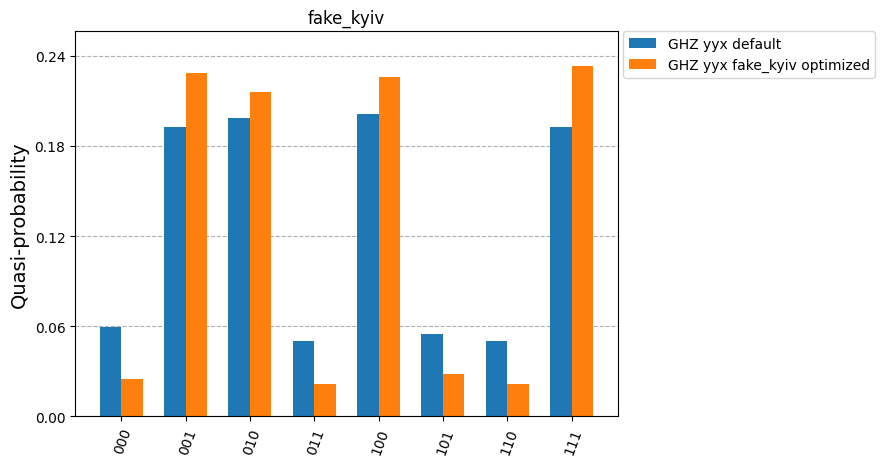

In [10]:
# compare results between original and coupling map optimized circuit on backend1
from qiskit import transpile

results_backend2_coupling = []

sampler = Sampler(mode=backend2)
sampler.options.default_shots=shots

circuits = [ghz, ghz_backend2]

for circuit in circuits:
    
    transpiled_circuit = transpile(circuit, backend=backend2, optimization_level=0)

    counts = sampler.run([transpiled_circuit]).result()[0].data.c.get_counts() # get results
    state_accuracy = get_state_accuracy(counts) # calculate state accuracy
    results_backend2_coupling.append((circuit.name, counts, state_accuracy)) # store
    

print("State Accuracy \n"+
      "\n".join([str(circuit_name)+': '+str(state_accuracy) 
                 for circuit_name, counts, state_accuracy in results_backend2_coupling]))

plot_distribution([counts for circuit_name, counts, state_accuracy in results_backend2_coupling],
               legend=[circuit_name for circuit_name, counts, state_accuracy in results_backend2_coupling],
               title=backend2.backend_name,
               bar_labels=False)

As you can see, the state accuracy improved by around 5-12% (depending on runs) on our system!

**Error Map based optimization**

As mentioned, this was one of two ways we are considering to manually optimize the circuits. The second builds off of the results from the coupling map based optimization and additionally takes into account the error rates. For this, we have another look on the error map and pick qubits that have the least single qubit gate, multiple qubit gate and readout error rate (see colors for intuition). Sometimes you need to trade off between these as for instance some qubits have excellent read out error rates while not as good single qubit gate error rates. Though, as this approach is manual, you don not need to try out each possible configuration to find the best one.

Backend 2:

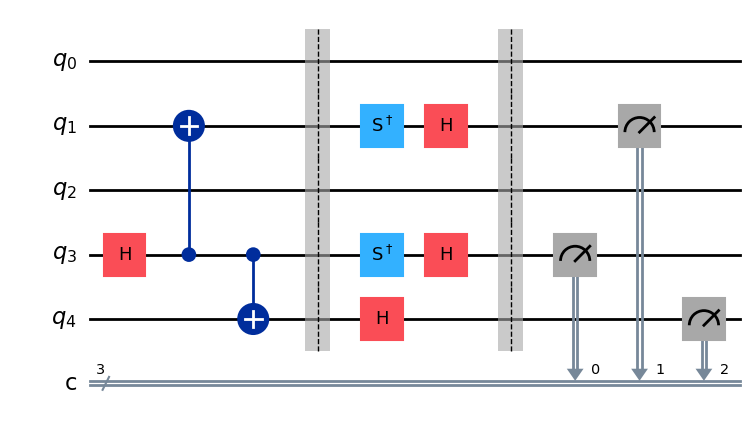

In [11]:
# backend2: create coupling map + error rate optimised circuit

# map: qubit 0 -> qubit 3
# qubit 1 -> qubit 1
# qubit 2 -> qubit 4

ghz_backend2_error = QuantumCircuit(5,3, name=f"GHZ yyx {backend2.backend_name} error rate optimised") # note that we use 5 qubits here to match the configuration of the device
ghz_backend2_error.h(3) # qubit with best adjacent multi-qubit gates error rates (cnot)
ghz_backend2_error.cx(3,1)
ghz_backend2_error.cx(3,4) 
ghz_backend2_error.barrier()
ghz_backend2_error.sdg([3,1]) # avoid 4 as it has a worse single qubit error rate
ghz_backend2_error.h([3,1,4]) # best readout error rates
ghz_backend2_error.barrier()
ghz_backend2_error.measure([3,1,4], range(n)) # readout still in same order
ghz_backend2_error.draw("mpl")


State Accuracy 
GHZ yyx default: 78.525%
GHZ yyx fake_kyiv optimized: 90.4%
GHZ yyx fake_kyiv error rate optimised: 94.9375%


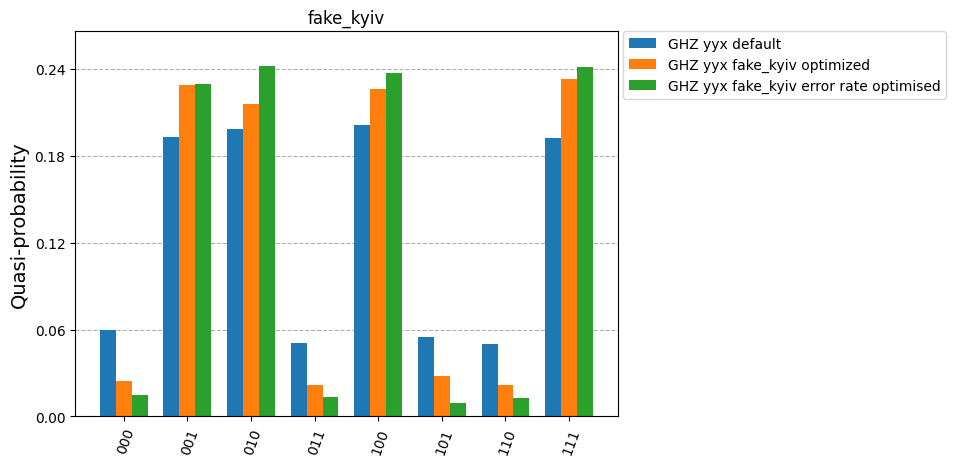

In [12]:
# compare results between original, coupling map, and error rates optimized circuit on backend2
results_backend2_error = []

sampler = Sampler(mode=backend2)
sampler.options.default_shots=shots

circuits = [ghz_backend2_error]

for circuit in circuits:
    transpiled_circuit = transpile(circuit, backend=backend2, optimization_level=0)
    counts = sampler.run([transpiled_circuit]).result()[0].data.c.get_counts() # get results
    state_accuracy = get_state_accuracy(counts) # calculate state accuracy
    results_backend2_error.append((circuit.name, counts, state_accuracy)) # store
    

print("State Accuracy \n"+
      "\n".join([str(circuit_name)+': '+str(state_accuracy) 
                 for circuit_name, counts, state_accuracy in results_backend2_coupling+results_backend2_error]))

plot_distribution([counts for circuit_name, counts, state_accuracy in results_backend2_coupling+results_backend2_error],
               legend=[circuit_name for circuit_name, counts, state_accuracy in results_backend2_coupling+results_backend2_error],
               title=backend2.backend_name,
               bar_labels=False)

As can be seen, the results from the coupling map and error rate optimised circuit are around the same as those from the circuit only optimised for its coupling map. This is because while the new circuit uses qubits with improved CNOT error rates, the old one natively had good readout error rates so that effects of swapping qubit mappings do not produce a significantly better result. However, there might be still a better circuit layout than the one found here.

## 3. Qiskit Transpiler Optimization<a name=transpiler><a/>
[[Top](#top)]

Qiskit comes with a built-in transpiler to translate logical circuits into circuits that are executable on the target backend. In addition, the transpile function (and execute function calling it) has four different levels of optimization available that can be set as parameter. See an extract of the [documentation](https://qiskit.org/documentation/apidoc/transpiler_preset.html) here to understand their differences:

Optimization Levels

* Level 0: no explicit optimization other than **mapping to backend**.

* level 1: light optimization by simple **adjacent gate collapsing**.

* level 2: medium optimization by **initial layout selection** and **gate cancellation** using commutativity rules.

* level 3: heavy optimization by **noise adaptive qubit mapping** and gate cancellation using commutativity rules and **unitary synthesis**.m

Next to other actions taken such as combining gates and mapping to the device's coupling map (which takes place necessarily on every level), note that only optimization level 3 applies noise adaptive mapping, which we attempted to do manually in the previous chapter.

To separately view the effects from each chapter, we will now again use the basic GHZ YYX circuit and compare the different transpiler optimization levels on backend 2.

State Accuracy 
optimization_level_0: 78.3125%
optimization_level_1: 97.82499999999999%
optimization_level_2: 98.02499999999999%
optimization_level_3: 98.575%


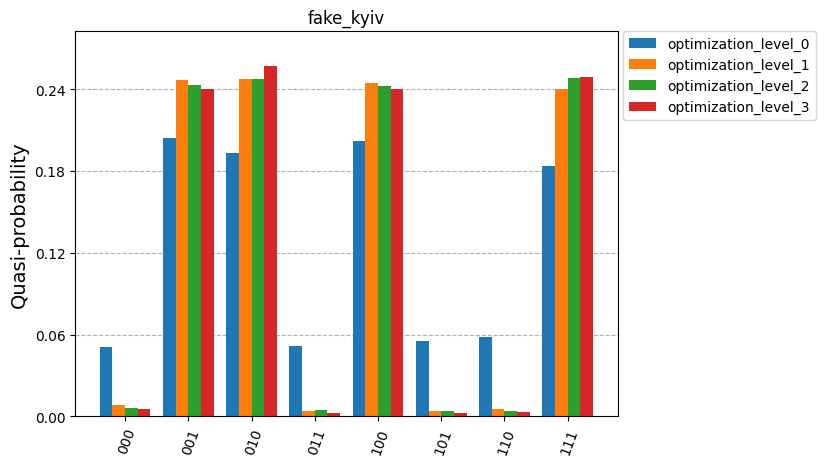

In [37]:
# compare results from different optimization levels on backend 2
results_backend2_transpiler = []

optimization_levels = [0,1,2,3]

sampler=Sampler(mode=backend2)
sampler.options.default_shots=shots

for optim_level in optimization_levels:

    transpiled_circuit = transpile(ghz, backend=backend2, optimization_level=optim_level)

    counts = sampler.run([transpiled_circuit]).result()[0].data.c.get_counts() # get results
    state_accuracy = get_state_accuracy(counts) # calculate state accuracy
    results_backend2_transpiler.append((optim_level, counts, state_accuracy)) # store
    
# compare state accuracies
print("State Accuracy \n"+
      "\n".join(["optimization_level_"+str(optim_level)+': '+str(state_accuracy) 
                 for optim_level, counts, state_accuracy in results_backend2_transpiler]))

# plot results
plot_distribution([counts for optim_level, counts, state_accuracy in results_backend2_transpiler],
               legend=["optimization_level_"+str(optim_level) for optim_level, counts, state_accuracy in results_backend2_transpiler],
               title=backend2.backend_name,
               bar_labels=False)

Did you notice? Counterintuively, there was only a visible improvement from optimization level 0 to 1, while level 1, 2 and 3 produce similar results on the backend. But why is there no improvement on each level? To understand this phenomenon better, let's see what happens under the hood by inspecting the transpiled circuits that the transpiler produces to execute them on our backend:

original circuit


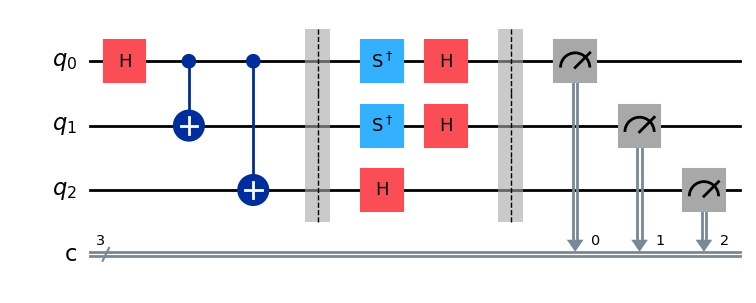

In [14]:
# compare transpiled circuits for different optimization levels on backend 2

optimization_levels = [0,1,2,3]
print("original circuit")
ghz.draw("mpl")

optimization level: 0 

optimization level: 1 

optimization level: 2 

optimization level: 3 



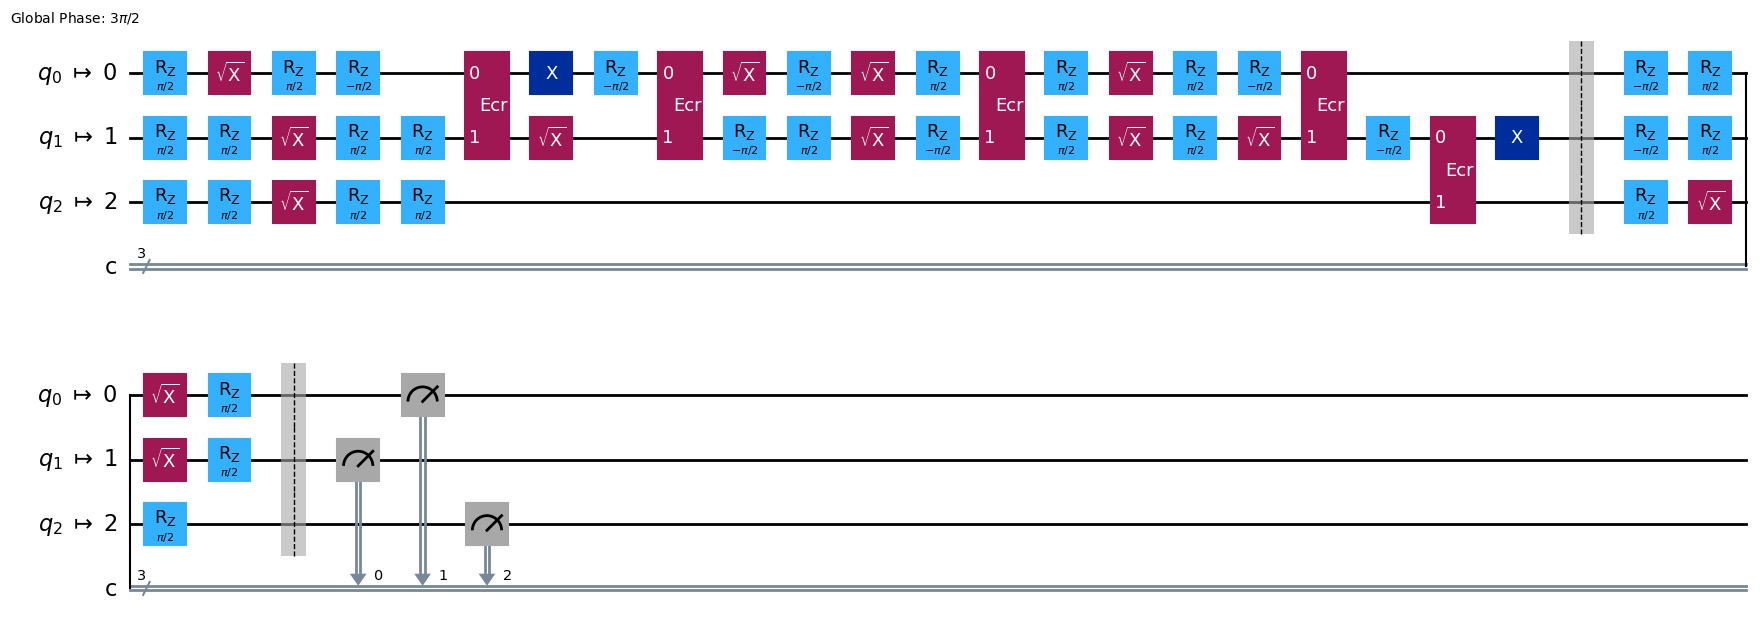

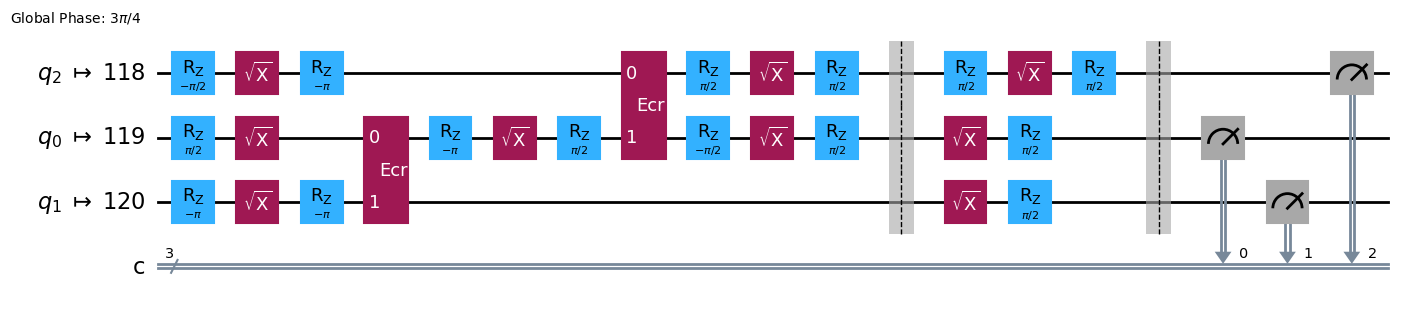

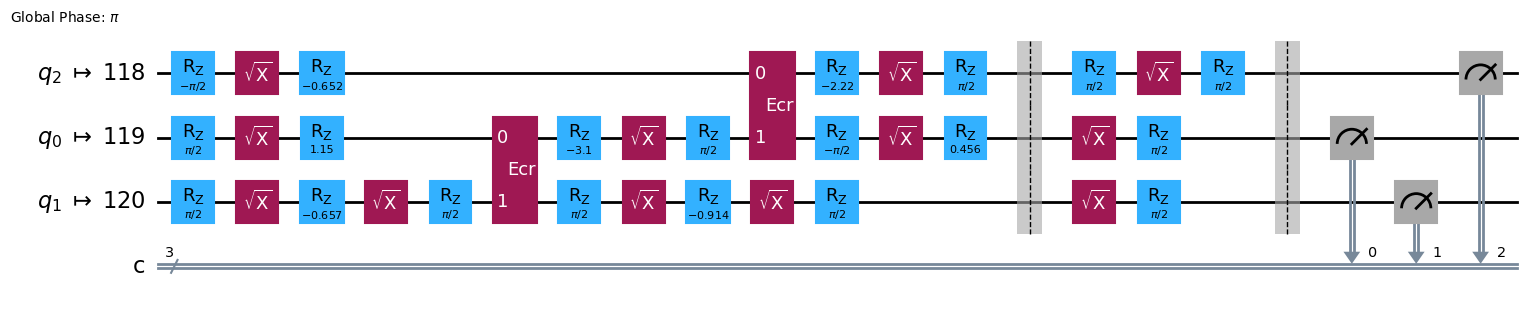

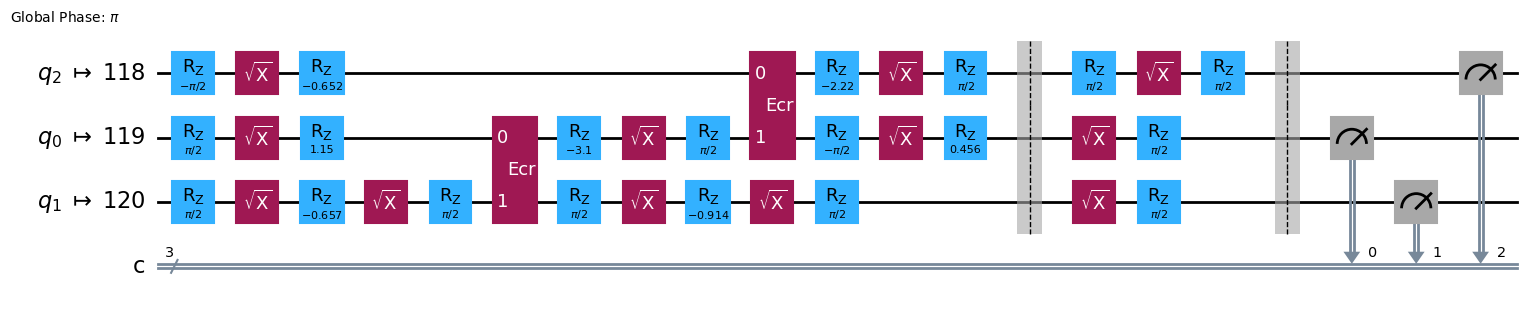

In [16]:
%matplotlib inline

for optim_level in optimization_levels:
    print(f"optimization level: {optim_level} \n")
    transpiled_circuit = transpile(ghz, backend=backend2, optimization_level=optim_level)
    transpiled_circuit.draw("mpl", idle_wires=False)

The circuits of level 2 and 3 are identical! Also circuits 0 and 1 behave similarly, even though the compiler picks different qubits to map our circuit. This implies that the circuit with optimization level 2 is already the best the transpiler can do for us. The small deviation between optimization level 2 and 3 only comes due to probabilistic quantum readout randomness.

Remember that the compiler is supposed to follow the idea from our manual optimization in a more sophisticated manner. Therefore let's compare its output again with what we produced in chapter 2:

manual optimization
State Accuracy
manual optimization:  94.5875%
transpiler optimization: 98.3375%


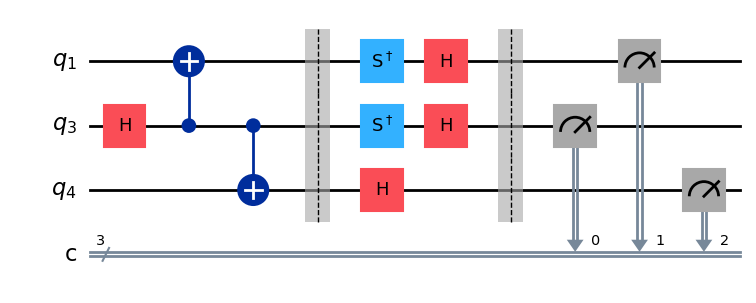

In [33]:
print("manual optimization")
ghz_backend2_error.draw("mpl", idle_wires=False)
        
print("State Accuracy")
print("manual optimization:  "+str(results_backend2_error[0][2]))
print("transpiler optimization: "+str(results_backend2_transpiler[3][2]))

As can be seen, the structure of the circuit remains the same even on level 3 of the transpiler optimized circuit, matching our circuit from chapter 2. However, they differ in the qubits that were selected for mapping the logical circuit onto the real physical hardware. Taking this into account, the transpiler apparently has a better intuition on how to balance the importances of different kinds of errors.

### Pass Manager
In the first chapter it has been used a different method to transpile the circuit, it's called Pass Manager:
a pass manager is an object that stores a list of transpiler passes and can execute them on a circuit. Create a pass manager by initializing a PassManager with a list of transpiler passes. To run the transpilation on a circuit, call the run method with a circuit as input.

It is very useful in the context of running various circuits and taking the output of the previous one as input for the following one. It is also very useful to have a fine-grained control on the various stages of transpilation.

This is not an objective of the notebook, so I'll leave to you to go into detail of this: https://docs.quantum.ibm.com/guides/transpile-with-pass-managers

## 4. Best system ..? <a name=mem><a/>
[[Top](#top)]

We improved the performance on the backend (FakeKyiv) that reported the worst results on the circuit proposed, with no optimization. Other systems performed very well though, so let's see how well the transpilation embedded in Qiskit works with those that already performed well.

In [67]:
backend1.backend_name

'fake_sherbrooke'

State Accuracy 
optimization_level_0: 94.15%
optimization_level_1: 97.225%
optimization_level_2: 97.3625%
optimization_level_3: 97.32499999999999%


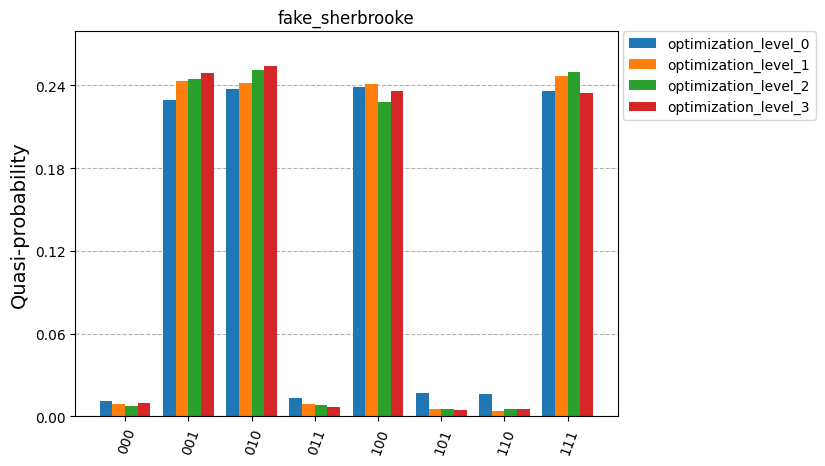

In [27]:
results_backend1_transpiler = []

optimization_levels = [0,1,2,3]

sampler=Sampler(mode=backend1)
sampler.options.default_shots=shots

for optim_level in optimization_levels:

    transpiled_circuit = transpile(ghz, backend=backend1, optimization_level=optim_level)

    counts = sampler.run([transpiled_circuit]).result()[0].data.c.get_counts() # get results
    state_accuracy = get_state_accuracy(counts) # calculate state accuracy
    results_backend1_transpiler.append((optim_level, counts, state_accuracy)) # store
    
# compare state accuracies
print("State Accuracy \n"+
      "\n".join(["optimization_level_"+str(optim_level)+': '+str(state_accuracy) 
                 for optim_level, counts, state_accuracy in results_backend1_transpiler]))

# plot results
plot_distribution([counts for optim_level, counts, state_accuracy in results_backend1_transpiler],
               legend=["optimization_level_"+str(optim_level) for optim_level, counts, state_accuracy in results_backend1_transpiler],
               title=backend1.backend_name,
               bar_labels=False)

As we can see backends that have high accuracy without transpliation optimization, not always have better accuracy after proceeding with the optimization, this emphasize the fundamental role that this optimization cover.
In the end Kyiv system have better accuracy on this circuit results after performing an optimized transpilation with respect to Sheerbrooke, that initially seemed to perform better!



---

Congratulations! In this tutorial, we found ways to greatly increase the probability with which we can win the Quantum GHZ game on a quantum computer. Please note that there is a large field of research revolving around optimising quantum hardware and software - and we only covered a few simple ones of them. Therefore feel free to dig deeper into the topic or run your own circuits on [IBM Quantum Experience](quantum-computing.ibm.com).

Thank you!

*Lennart Schulze, IBM Germany, lennart.schulze@ibm.com*

*Dr. Jan-Rainer Lahmann, IBM Germany, Jan.Lahmann@de.ibm.com*

updated by *Davide Moretti, IBM Italy, davide.moretti1@ibm.com*

---
## .
## .
## .
## .


## *Appendix*<a name=appendix><a/>
[[Top](#top)]


### Running this notebook on real quantum computers<a name=appendix></a>

You can run the entire on real quantum hardware provided and made accesible by IBM on the [IBM Quantum Experience](https://quantum-computing.ibm.com).
You should take into consideration that this will take longer, as each job submitted for execution to either of the quantum computers is queued based on a fair share algorithm. Therefore, you will most likely need to wait until other jobs queued before yours are finished. You can see the status of your jobs under "Pending Results" on the [Results page](https://quantum-computing.ibm.com/results).

As the first chapter executes circuits on all suitable devices, it will take especially long. For this reason we'll provide guidance for that chapter seperately.

**Connect IBM Quantum Experience Account**

We need to connect to our IBM Quantum Experience account in order to be able to execute the results on real hardware.

If you haven't linked your IBM Quantum Experience Account yet, follow this [guide](https://qiskit.org/documentation/install.html#install-access-ibm-q-devices-label) and paste your credentials in the following cell. Remember to remove your credentials at the [end of the tutorial](#end).

In [ ]:
# save IBM Quantum Experience account credentials
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(channel="ibm_quantum", token='put your API token here')

**Using real Quantum Computers in chapter 1**

We simply need to change the "backend" variable. Just execute the following cell or use it to replace the corresponding cell above, then execute the cell in chapter 1 in which the circuits are executed and review the results.

In [18]:
print("Available backends:")
service.backends()

Available backends:


[<IBMBackend('ibm_brisbane')>,
 <IBMBackend('ibm_kyiv')>,
 <IBMBackend('ibm_sherbrooke')>]

**Using real Quantum Computers in chapters 2-5**

First, we need to change our backend variables for the real devices we would like to examine. You can pick the real devices corresponding to the mock ones we used above or choose your own based on the selection returned by the previous cell. (Again execute the cell here or replace the code in the corresponding cell above.)

In [4]:
# higher accuracy
backend1 = service.backend("ibm_sherbrooke")

# lower accuracy
backend2 = service.backend("ibm_kyiv")

Let's take ibm_kyiv for example.

State Accuracy 
97.625%


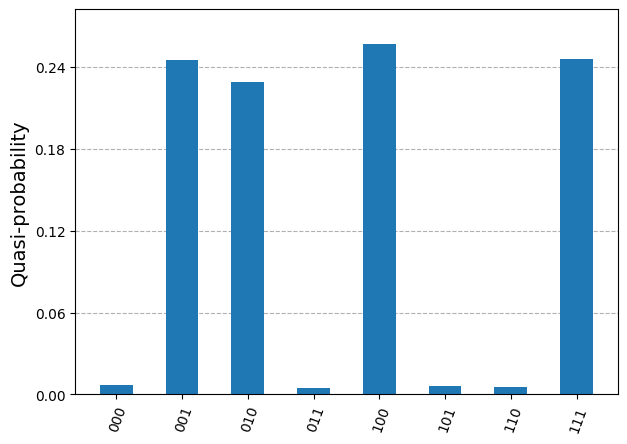

In [ ]:
# compare results from different optimization levels on backend 2

sampler = Sampler(mode=backend2)
sampler.options.default_shots=shots

transpiled_circuit = transpile(ghz, backend=backend2, optimization_level=2)

counts = sampler.run([transpiled_circuit]).result()[0].data.c.get_counts() # get results

state_accuracy = get_state_accuracy(counts) # calculate state accuracy

# compare state accuracies
print("State Accuracy \n"+ state_accuracy)

# plot results
plot_distribution(counts, bar_labels=False)